In [ ]:
!pip install category_encoders==2.*

In [ ]:
!pip install texthero

In [ ]:
#!python -m spacy download en_core_web_lg

In [ ]:
# importing all the libraries 

import pandas as pd
import numpy as np
import random
import sklearn

# libraries for plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import plotly.express as px
from wordcloud import WordCloud, ImageColorGenerator

# Natural Language Processing 
import nltk
from nltk import sent_tokenize, word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# to split the dataset into test and train 
from sklearn.model_selection import StratifiedShuffleSplit

# Transformers for the Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Evaluation metrics
from sklearn.metrics import mean_absolute_error

# Cross Validation libraries
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# Predictors 
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.svm import LinearSVR

# feature Importances 
from sklearn.inspection import permutation_importance

# For deployment 
import joblib           # pickle the pipeline
from joblib import dump
import texthero as hero

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [ ]:
df = df.dropna()

In [ ]:
df['cancellation_policy'].value_counts()

strict             19459
moderate           11339
flexible            7318
super_strict_30       33
super_strict_60        4
Name: cancellation_policy, dtype: int64

In [ ]:
1 - 1

0

In [ ]:
def wrangle(X):
  # make a copy
  X = X.copy()

  # encode "t" and "f" as 1's and 0's
  X['host_has_profile_pic'][X['host_has_profile_pic']=='t'] = 1
  X['host_has_profile_pic'][X['host_has_profile_pic']=='f'] = 0

  X['host_identity_verified'][X['host_identity_verified']=='t'] = 1
  X['host_identity_verified'][X['host_identity_verified']=='f'] = 0

  X['instant_bookable'][X['instant_bookable']=='t'] = 1
  X['instant_bookable'][X['instant_bookable']=='f'] = 0

  # Group some of the many property types together
  X['property_type'][X['property_type'].isin(['Boat','Tent','Castle','Yurt', 'Hut', 'Treehouse',
                                              'Chalet','Earth House','Tipi','Cave',
                                              'Train','Parking Space','Island','Casa particular',
                                              'Lighthouse', 'Vacation home', 'Serviced apartment',
                                              'Guest suite', 'Camper/RV', 'Timeshare', 'Cabin',
                                              'In-law', 'Hostel', 'Boutique hotel'])] = 'Other'

  # columns with unusable variance
  unusable_variance = ['zipcode']

  # columns with high percentage of missing values

  # categorical values with high cardinality
  # 'neighborhood' has 620 and 'thumbnail_url' has many thousands
  high_card = ['thumbnail_url','name', 'id']

  # Get the price and drop the log of price
  X['price'] = np.exp(X['log_price'])
  X = X.drop(['log_price'] + unusable_variance + high_card, axis=1)

  # Remove the upper 1% outliers in price
  X = X[(X['price'] <= np.percentile(X['price'], 99.0))]

  return X

In [ ]:
df = wrangle(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38153 entries, 1 to 74110
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           38153 non-null  object 
 1   room_type               38153 non-null  object 
 2   amenities               38153 non-null  object 
 3   accommodates            38153 non-null  int64  
 4   bathrooms               38153 non-null  float64
 5   bed_type                38153 non-null  object 
 6   cancellation_policy     38153 non-null  object 
 7   cleaning_fee            38153 non-null  bool   
 8   city                    38153 non-null  object 
 9   description             38153 non-null  object 
 10  first_review            38153 non-null  object 
 11  host_has_profile_pic    38153 non-null  object 
 12  host_identity_verified  38153 non-null  object 
 13  host_response_rate      38153 non-null  object 
 14  host_since              38153 non-null

In [ ]:
df.describe()

,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,price
count,38153.000000,38153.00000,38153.000000,38153.000000,38153.000000,38153.000000,38153.000000,38153.000000,38153.000000
mean,3.181034,1.19853,38.766482,-90.825784,33.141221,94.313946,1.230965,1.731581,138.285063
std,2.043987,0.50837,3.005864,21.422290,45.561042,6.871662,0.795325,1.233659,99.190989
min,1.000000,0.00000,33.705835,-122.511500,1.000000,20.000000,0.000000,0.000000,1.000000
25%,2.000000,1.00000,34.187204,-118.323917,5.000000,92.000000,1.000000,1.000000,73.000000
50%,2.000000,1.00000,40.682743,-74.001367,16.000000,96.000000,1.000000,1.000000,110.000000
75%,4.000000,1.00000,40.760737,-73.949045,42.000000,99.000000,1.000000,2.000000,175.000000
max,16.000000,8.00000,42.390437,-71.000462,542.000000,100.000000,10.000000,16.000000,700.000000


In [ ]:
num_df = df[['accommodates', 'bathrooms', 'latitude', 'longitude', 'review_scores_rating', 'number_of_reviews', 'bedrooms', 'beds', 'price']]
print(num_df.shape)
num_df.head()

(38153, 9)


,accommodates,bathrooms,latitude,longitude,review_scores_rating,number_of_reviews,bedrooms,beds,price
1,7,1.0,40.766115,-73.989040,93.0,6,3.0,3.0,169.0
2,5,1.0,40.808110,-73.943756,92.0,10,1.0,3.0,145.0
5,2,1.0,37.753164,-122.429526,100.0,3,1.0,1.0,85.0
7,2,1.0,34.046737,-118.260439,93.0,9,1.0,1.0,120.0
8,2,1.0,37.781128,-122.501095,99.0,159,1.0,1.0,120.0


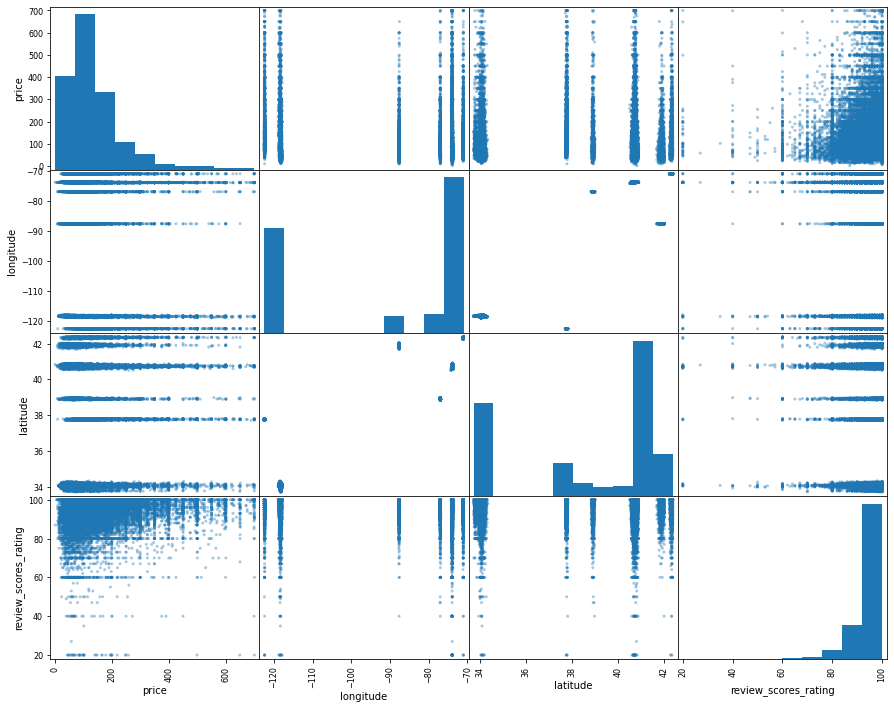

In [ ]:
cols = ['price','longitude', 'latitude', 'review_scores_rating']


scatter_matrix(num_df[cols], alpha=0.4, figsize=(15,12))
plt.savefig(r"figure.png")
plt.show()

In [ ]:
target = 'price'
y = num_df[target]

X = num_df.drop([target], axis=1)

In [ ]:
# Train-val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((30522, 8), (7631, 8), (30522,), (7631,))

In [ ]:
# Get baseline MAE

baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print('Baseline MAE:', baseline)

Baseline MAE: 70.39789126937613


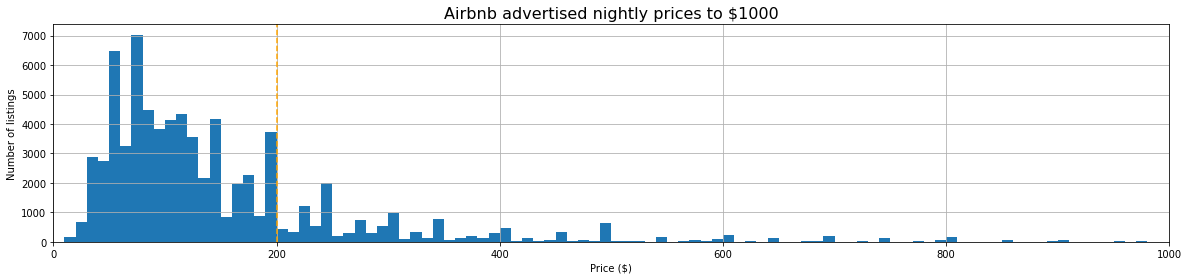

In [ ]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
num_df['int_price'].hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ImputerDF(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
        self.cols = []
        
    def fit(self, X, y=None):
        self.imputer.fit(X)
        self.cols = list(X.columns)
        return self
    
    def transform(self, X):
        X_t = self.imputer.transform(X)
        return pd.DataFrame(X_t, columns=self.cols)

In [ ]:
# making sure it works fine and outputs a dataframe before we apply it in the pipeline.
idf = ImputerDF()
idf.fit_transform(X_train.iloc[:5])

,accommodates,bathrooms,latitude,longitude,review_scores_rating,number_of_reviews,bedrooms,beds
0,3.0,1.0,37.731500,-122.433548,96.0,66.0,1.0,1.0
1,7.0,2.5,37.778040,-122.430841,96.0,56.0,4.0,4.0
2,2.0,1.0,41.837448,-87.618573,95.0,22.0,1.0,1.0
3,6.0,1.0,33.732013,-118.283991,86.0,17.0,3.0,3.0
4,3.0,1.0,40.724442,-73.979988,98.0,12.0,1.0,2.0


In [ ]:
# libraries for neural networks

import keras
from keras.models import Sequential
from keras.layers import Dense # to add the hidden layers

from keras.layers import Activation, Embedding, Flatten, BatchNormalization, LeakyReLU, PReLU, ELU
from keras.layers import Dropout # to add regularization if the model overfits
from keras.activations import relu, sigmoid
# performing hyperparameter optimization 

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Fitting the model
lin_reg = make_pipeline(
    OrdinalEncoder(),
    ImputerDF(),
    DecisionTreeRegressor())
lin_reg.fit(X_train, y_train)
training_preds_lin_reg = lin_reg.predict(X_train)
val_preds_lin_reg = lin_reg.predict(X_val)

# Printing the results
print('Training MAE:', mean_absolute_error(y_train, lin_reg.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, lin_reg.predict(X_val)))
print("\nTraining r2:", round(r2_score(y_train, training_preds_lin_reg),4))
print("Validation r2:", round(r2_score(y_val, val_preds_lin_reg),4))

Training MAE: 7.507700422076939e-17
Validation MAE: 51.368759009304156

Training r2: 1.0
Validation r2: 0.3515


In [ ]:
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Printing the model summary
print(nn2.summary())


# Training the model
nn2_history = nn2.fit(X_train, y_train,
           batch_size=32,
           epochs=10,
           validation_data=(X_val, y_val))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_64 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_65 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 257       
Total params: 100,225
Trainable params: 100,225
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
954/954 [==============================] - 2s 2ms/step - loss: 7187.5894 - mean_squared_error: 7187.5894 - val_loss: 6190.7148 - val_mean_squared_error: 6190.7148
Epoch 2/10
954/954 [==============================] - 2s 2ms/step 

In [ ]:


xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_val)




# Printing the results
print('Training MAE:', mean_absolute_error(y_train, lin_reg.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, lin_reg.predict(X_val)))
print("\nTraining r2:", round(r2_score(y_train, training_preds_lin_reg),4))
print("Validation r2:", round(r2_score(y_val, val_preds_lin_reg),4))

[06:23:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training MAE: 7.507700422076939e-17
Validation MAE: 51.368759009304156

Training r2: 1.0
Validation r2: 0.3515


In [ ]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
number_of_reviews,0.007631
beds,0.008590
review_scores_rating,0.028564
latitude,0.045460
longitude,0.062912
bathrooms,0.132785
accommodates,0.132901
bedrooms,0.581157


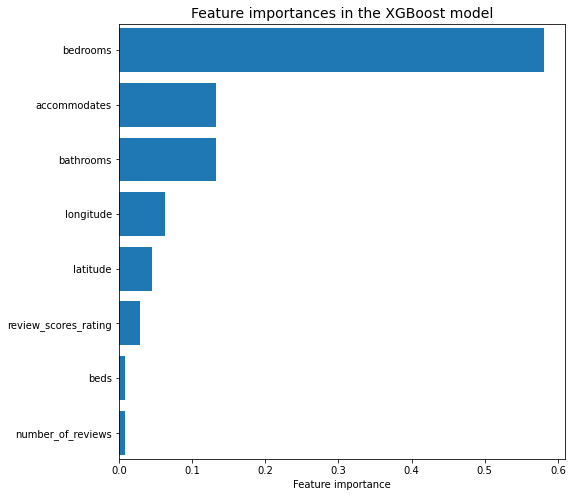

In [ ]:
# Plotting feature importances
plt.figure(figsize=(8,8))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [ ]:
# Building the model
nn2 = Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())



Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_68 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_69 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 257       
Total params: 100,225
Trainable params: 100,225
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Training the model

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=10,
                  batch_size=32,
                  validation_split = 0.1)



Epoch 1/10
859/859 [==============================] - 2s 2ms/step - loss: 7325.9009 - mean_squared_error: 7325.9009 - val_loss: 7351.3521 - val_mean_squared_error: 7351.3521
Epoch 2/10
859/859 [==============================] - 2s 2ms/step - loss: 6187.6724 - mean_squared_error: 6187.6724 - val_loss: 6435.7676 - val_mean_squared_error: 6435.7676
Epoch 3/10
859/859 [==============================] - 2s 2ms/step - loss: 6033.8911 - mean_squared_error: 6033.8911 - val_loss: 6191.4805 - val_mean_squared_error: 6191.4805
Epoch 4/10
859/859 [==============================] - 2s 2ms/step - loss: 5947.0342 - mean_squared_error: 5947.0342 - val_loss: 6009.5449 - val_mean_squared_error: 6009.5449
Epoch 5/10
859/859 [==============================] - 2s 2ms/step - loss: 5808.8159 - mean_squared_error: 5808.8159 - val_loss: 6059.1445 - val_mean_squared_error: 6059.1445
Epoch 6/10
859/859 [==============================] - 2s 2ms/step - loss: 5715.8872 - mean_squared_error: 5715.8872 - val_loss: 63

In [ ]:
# Building the model
nn3 = Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_72 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_73 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_74 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 513       
Total params: 232,065
Trainable params: 232,065
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Training the model


nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=1000,
                  batch_size=256,
                  validation_split = 0.1)


Epoch 1/1000
108/108 [==============================] - 0s 4ms/step - loss: 9853.1553 - mean_squared_error: 9813.7881 - val_loss: 8298.5186 - val_mean_squared_error: 8267.0527
Epoch 2/1000
108/108 [==============================] - 0s 3ms/step - loss: 6739.8911 - mean_squared_error: 6708.5938 - val_loss: 6709.2095 - val_mean_squared_error: 6678.3701
Epoch 3/1000
108/108 [==============================] - 0s 3ms/step - loss: 6288.5322 - mean_squared_error: 6258.1104 - val_loss: 6638.0073 - val_mean_squared_error: 6608.0059
Epoch 4/1000
108/108 [==============================] - 0s 3ms/step - loss: 6360.3003 - mean_squared_error: 6330.6377 - val_loss: 6538.1357 - val_mean_squared_error: 6508.7710
Epoch 5/1000
108/108 [==============================] - 0s 3ms/step - loss: 6160.6299 - mean_squared_error: 6131.5107 - val_loss: 6368.2534 - val_mean_squared_error: 6339.3540
Epoch 6/1000
108/108 [==============================] - 0s 3ms/step - loss: 6048.8506 - mean_squared_error: 6020.2012 - 

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
Xtest2 = sc_X.fit_transform(X_train)

In [ ]:
len(Xtest2)

30522

## NEW NOTEBOOK


In [ ]:
#load packages
import sys
print("Python version: {}". format(sys.version))
import pandas as pd
print("pandas version: {}". format(pd.__version__))
import numpy as np
print("NumPy version: {}". format(np.__version__))
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import sklearn
print("scikit-learn version: {}". format(sklearn.__version__))
from sklearn.metrics import make_scorer, mean_squared_error
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)
import os
#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
%matplotlib inline




Python version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
pandas version: 1.1.2
NumPy version: 1.18.5
scikit-learn version: 0.22.2.post1
-------------------------


In [ ]:
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')

#checking the data size
print("The train data size is : {} ".format(data_train.shape))
print("The test data size is : {} ".format(data_test.shape))

The test data size is : (25458, 28) 



 mu = 4.78 and sigma = 0.72



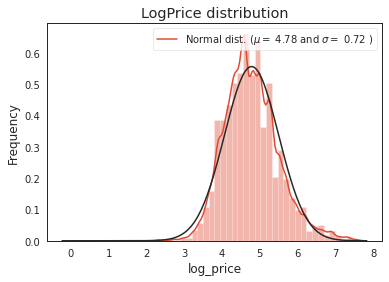

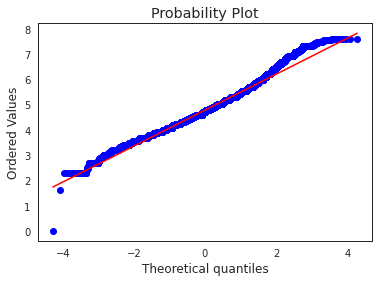

In [ ]:
import matplotlib.pyplot as plt
sns.distplot(data_train['log_price'] , fit=norm);
# Get the fitted parameters
(mu, sigma) = norm.fit(data_train['log_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogPrice distribution')
#the QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['log_price'], plot=plt)
plt.show()

In [ ]:
corr_mx = data_train.corr()
corr_mx["log_price"].sort_values(ascending=False)

log_price               1.000000
accommodates            0.567574
bedrooms                0.473212
beds                    0.442153
bathrooms               0.355420
cleaning_fee            0.111191
review_scores_rating    0.091219
latitude               -0.002193
id                     -0.007178
number_of_reviews      -0.032470
longitude              -0.047529
Name: log_price, dtype: float64

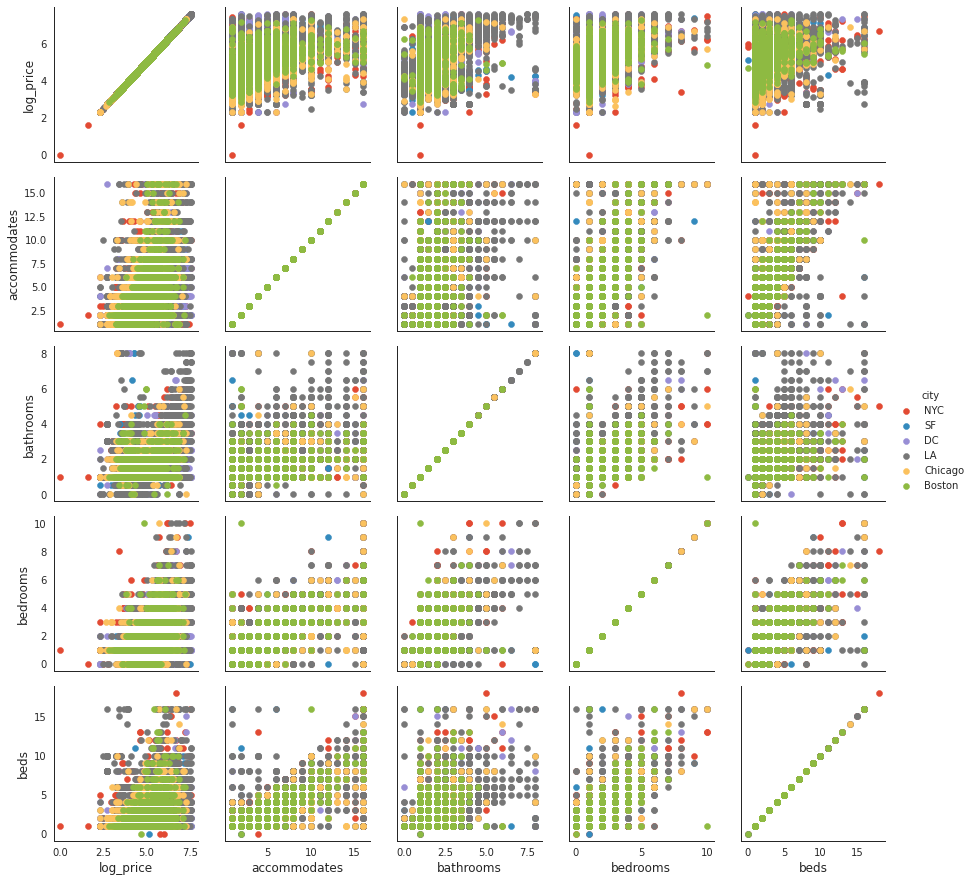

In [ ]:
g = sns.PairGrid(data_train, hue="city", vars=["log_price", "accommodates", "bathrooms","bedrooms", "beds" ])
g = g.map(plt.scatter)
g = g.add_legend()

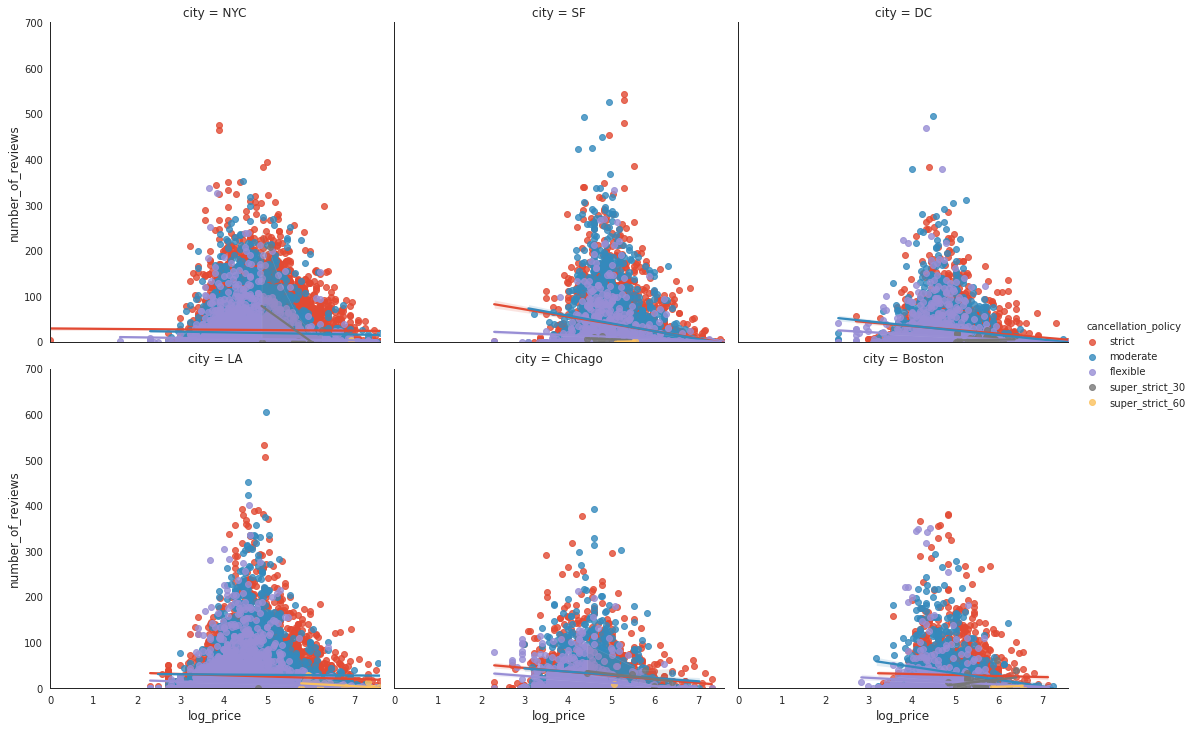

In [ ]:
g = sns.lmplot(x="log_price", y="number_of_reviews", col="city", col_wrap=3, hue='cancellation_policy', data=data_train)
g.set(ylim=(0, 700))

In [ ]:
import folium

MAPdata = data_train.copy()
MAPdata = MAPdata.sample(1000) #nlargest(100, 'log_price')
MAPdataloc = MAPdata[['latitude','longitude']]
MAPdatalist = MAPdataloc.values.tolist()

MAPdatat = data_test.copy()
MAPdatat = MAPdatat.sample(1000)
MAPdataloct = MAPdatat[['latitude','longitude']]
MAPdatalistt = MAPdataloct.values.tolist()



mapall = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

for point in range(0, len(MAPdatalist)):
    folium.Marker(MAPdatalist[point], icon=folium.Icon(color='red', icon='cloud')).add_to(mapall)
for point in range(0, len(MAPdatalistt)):
    folium.Marker(MAPdatalistt[point], icon=folium.Icon(color='blue', icon='cloud')).add_to(mapall)    
    
mapall

In [ ]:
"""from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    #Calculate the great circle distance between two points 
    #on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 3956 Radius of earth in miles.
    distance = c * r
    return distance"""

In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
for sentence in data_train['name'].values[:2]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

Beautiful brownstone 1-bedroom
compound: 0.5994, neg: 0.0, neu: 0.339, pos: 0.661, 
Superb 3BR Apt Located Near Times Square
compound: 0.6249, neg: 0.0, neu: 0.594, pos: 0.406, 


In [ ]:
name_f = [r for r in data_train['name']]
description_f = [r for r in data_train['description']]

In [ ]:
pscores = [sid.polarity_scores(comment) for comment in name_f]
pscoresd = [sid.polarity_scores(comment) for comment in description_f]

In [ ]:
data_train['name_compound'] = [score['compound'] for score in pscores]
data_train['name_negativity'] = [score['neg'] for score in pscores]
data_train['name_neutrality'] = [score['neu'] for score in pscores]
data_train['name_positivity'] = [score['pos'] for score in pscores]

data_train['desc_compound'] = [score['compound'] for score in pscoresd]
data_train['desc_negativity'] = [score['neg'] for score in pscoresd]
data_train['desc_neutrality'] = [score['neu'] for score in pscoresd]
data_train['desc_positivity'] = [score['pos'] for score in pscoresd]

In [ ]:
from datetime import datetime
from dateutil.parser import parse
from datetime import timedelta


def data_as_of(row):
    if (row['city']=='Boston'):
        return datetime.strptime('2017-10-06', '%Y-%m-%d').date()
    elif (row['city']=='NYC'):
        return datetime.strptime('2017-10-02', '%Y-%m-%d').date()
    elif (row['city']=='LA'):
        return datetime.strptime('2017-05-02', '%Y-%m-%d').date()   
    elif (row['city']=='SF'):
        return datetime.strptime('2017-10-02', '%Y-%m-%d').date()     
    elif (row['city']=='Chicago'):
        return datetime.strptime('2017-05-10', '%Y-%m-%d').date()    
    elif (row['city']=='DC'):
        return datetime.strptime('2017-05-10', '%Y-%m-%d').date() 

data_train['data_as_of']=data_train.apply(lambda row: data_as_of(row), axis=1)

In [ ]:
#data_train['data_as_of']
data_train['first_review'] = pd.to_datetime(data_train['first_review'])
data_train['host_since'] = pd.to_datetime(data_train['host_since'])
data_train['last_review'] = pd.to_datetime(data_train['last_review'])

In [ ]:
data_train['first_review'] = data_train['first_review'].apply(lambda x: x.date())
data_train['host_since'] = data_train['host_since'].apply(lambda x: x.date())
data_train['last_review'] = data_train['last_review'].apply(lambda x: x.date())

In [ ]:

data_train['DateDiffFirstReview'] = (data_train.data_as_of - data_train.first_review)/ np.timedelta64(1, 'D')
data_train['DateDiffHostSince'] = (data_train.data_as_of - data_train.host_since)/ np.timedelta64(1, 'D')
data_train['DateDiffLastReview'] = (data_train.data_as_of - data_train.last_review)/ np.timedelta64(1, 'D')

In [ ]:
data_train['DateDiffFirstReview'].fillna(0, inplace=True)
data_train['DateDiffHostSince'].fillna(0, inplace=True)
data_train['DateDiffLastReview'].fillna(0, inplace=True)

In [ ]:
data_train['thumbnail_url'].fillna(0, inplace=True)

def picture(row):
    if (row['thumbnail_url']==0):
        return 0
    else:
        return 1
    
data_train['picture']=data_train.apply(lambda row: picture(row), axis=1)

In [ ]:
data_train['amenities'] = data_train['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))

In [ ]:
np.concatenate(data_train['amenities'].map(lambda amns: amns.split("|")).values)


array(['Wireless Internet', 'Air conditioning', 'Kitchen', ..., 'Hangers',
       'Hair dryer', 'Laptop friendly workspace'], dtype='<U42')

In [ ]:
amenities = np.unique(np.concatenate(data_train['amenities'].map(lambda amns: amns.split("|")).values))
amenities_matrix = np.array([data_train['amenities'].map(lambda amns: amn in amns).values for amn in amenities])

In [ ]:
data_train['amenities'].head()

0    Wireless Internet|Air conditioning|Kitchen|Hea...
1    Wireless Internet|Air conditioning|Kitchen|Hea...
2    TV|Cable TV|Wireless Internet|Air conditioning...
3    TV|Cable TV|Internet|Wireless Internet|Kitchen...
4    TV|Internet|Wireless Internet|Air conditioning...
Name: amenities, dtype: object

In [ ]:
data_train['amenities'].map(lambda amns: amns.split("|")).head()


0    [Wireless Internet, Air conditioning, Kitchen,...
1    [Wireless Internet, Air conditioning, Kitchen,...
2    [TV, Cable TV, Wireless Internet, Air conditio...
3    [TV, Cable TV, Internet, Wireless Internet, Ki...
4    [TV, Internet, Wireless Internet, Air conditio...
Name: amenities, dtype: object

In [ ]:
np.unique(np.concatenate(data_train['amenities'].map(lambda amns: amns.split("|"))))

array(['', ' smooth pathway to front door', '24-hour check-in',
       'Accessible-height bed', 'Accessible-height toilet',
       'Air conditioning', 'Air purifier', 'BBQ grill', 'Baby bath',
       'Baby monitor', 'Babysitter recommendations', 'Bath towel',
       'Bathtub', 'Bathtub with shower chair', 'Beach essentials',
       'Beachfront', 'Bed linens', 'Body soap', 'Breakfast',
       'Buzzer/wireless intercom', 'Cable TV', 'Carbon monoxide detector',
       'Cat(s)', 'Changing table', 'Children’s books and toys',
       'Children’s dinnerware', 'Cleaning before checkout',
       'Coffee maker', 'Cooking basics', 'Crib', 'Disabled parking spot',
       'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman',
       'Doorman Entry', 'Dryer', 'EV charger', 'Elevator',
       'Elevator in building', 'Essentials', 'Ethernet connection',
       'Extra pillows and blankets', 'Family/kid friendly',
       'Fire extinguisher', 'Fireplace guards', 'Firm matress',
       'Firm mattress

In [ ]:
amenities = np.unique(np.concatenate(data_train['amenities'].map(lambda amns: amns.split("|"))))[1:]
amenity_arr = np.array([data_train['amenities'].map(lambda amns: amn in amns) for amn in amenities])
amenity_arr


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
len(data_train.columns)

42

In [ ]:
features = data_train[['accommodates', 'host_response_rate','city', 'bathrooms', 'cleaning_fee', 'bedrooms', 'beds', 'log_price', 'number_of_reviews',
                     'review_scores_rating','cancellation_policy', 'property_type', 'room_type', 'bed_type', 'host_identity_verified',
                     'host_has_profile_pic', 'instant_bookable','picture',
                     'name_positivity','desc_positivity','DateDiffFirstReview',
                     'DateDiffHostSince','DateDiffLastReview']]

In [ ]:
len(features.columns)

23

In [ ]:
features.head()

,accommodates,host_response_rate,city,bathrooms,cleaning_fee,bedrooms,beds,log_price,number_of_reviews,review_scores_rating,cancellation_policy,property_type,room_type,bed_type,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview
0,3,NaN,NYC,1.0,True,1.0,1.0,5.010635,2,100.0,strict,Apartment,Entire home/apt,Real Bed,t,t,f,1,0.661,0.268,471.0,2016.0,441.0
1,7,100%,NYC,1.0,True,3.0,3.0,5.129899,6,93.0,strict,Apartment,Entire home/apt,Real Bed,f,t,t,1,0.406,0.164,58.0,105.0,9.0
2,5,100%,NYC,1.0,True,1.0,3.0,4.976734,10,92.0,moderate,Apartment,Entire home/apt,Real Bed,t,t,t,1,0.000,0.120,155.0,342.0,18.0
3,4,NaN,SF,1.0,True,2.0,2.0,6.620073,0,NaN,flexible,House,Entire home/apt,Real Bed,t,t,f,1,0.411,0.178,0.0,897.0,0.0
4,2,100%,DC,1.0,True,0.0,1.0,4.744932,4,40.0,moderate,Apartment,Entire home/apt,Real Bed,t,t,t,0,0.506,0.131,729.0,801.0,108.0


In [ ]:
for tf_feature in ['host_identity_verified', 'host_has_profile_pic', 'instant_bookable']:
    features[tf_feature] = features[tf_feature].map(lambda s: False if s == "f" else True)

In [ ]:
list(features.columns.values)

['accommodates',
 'host_response_rate',
 'city',
 'bathrooms',
 'cleaning_fee',
 'bedrooms',
 'beds',
 'log_price',
 'number_of_reviews',
 'review_scores_rating',
 'cancellation_policy',
 'property_type',
 'room_type',
 'bed_type',
 'host_identity_verified',
 'host_has_profile_pic',
 'instant_bookable',
 'picture',
 'name_positivity',
 'desc_positivity',
 'DateDiffFirstReview',
 'DateDiffHostSince',
 'DateDiffLastReview']

In [ ]:
for categorical_feature in ['cancellation_policy', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(features[categorical_feature])], axis=1)

In [ ]:
host_response_r = []
for i in features['host_response_rate']:
    i = str(i)
    i = i.strip('%')
    i = float(i)
    host_response_r.append(i)

features['host_response_rate'] = host_response_r
features.drop(['host_response_rate'], axis = 1, inplace = True)
print(features.shape)
features.head()

In [ ]:
print(features.shape)
features.head()

(74111, 70)


,accommodates,bathrooms,cleaning_fee,bedrooms,beds,number_of_reviews,review_scores_rating,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,flexible,moderate,strict,super_strict_30,super_strict_60,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Casa particular,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,Hut,In-law,Island,Lighthouse,Loft,Other,Parking Space,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
0,3,1.0,True,1.0,1.0,2,100.0,True,True,False,1,0.661,0.268,471.0,2016.0,441.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,7,1.0,True,3.0,3.0,6,93.0,False,True,True,1,0.406,0.164,58.0,105.0,9.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,5,1.0,True,1.0,3.0,10,92.0,True,True,True,1,0.000,0.120,155.0,342.0,18.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,1.0,True,2.0,2.0,0,96.0,True,True,False,1,0.411,0.178,0.0,897.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,2,1.0,True,0.0,1.0,4,40.0,True,True,True,0,0.506,0.131,729.0,801.0,108.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
features = pd.concat([features, pd.get_dummies(features['city'])], axis=1)
features.drop(['city','cancellation_policy', 'property_type', 'room_type', 'bed_type'], axis = 1, inplace = True)
features.head()

,accommodates,bathrooms,cleaning_fee,bedrooms,beds,log_price,number_of_reviews,review_scores_rating,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,flexible,moderate,strict,super_strict_30,super_strict_60,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Casa particular,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,Hut,In-law,Island,Lighthouse,Loft,Other,Parking Space,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
0,3,1.0,True,1.0,1.0,5.010635,2,100.0,True,True,False,1,0.661,0.268,471.0,2016.0,441.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,7,1.0,True,3.0,3.0,5.129899,6,93.0,False,True,True,1,0.406,0.164,58.0,105.0,9.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,5,1.0,True,1.0,3.0,4.976734,10,92.0,True,True,True,1,0.000,0.120,155.0,342.0,18.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,1.0,True,2.0,2.0,6.620073,0,NaN,True,True,False,1,0.411,0.178,0.0,897.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,2,1.0,True,0.0,1.0,4.744932,4,40.0,True,True,True,0,0.506,0.131,729.0,801.0,108.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
features.shape

(74111, 71)

In [ ]:
for col in features.columns[features.isnull().any()]:
    print(col)

bathrooms
bedrooms
beds
review_scores_rating


In [ ]:
for col in features.columns[features.isnull().any()]:
    features[col] = features[col].fillna(features[col].median())

In [ ]:
featuresy = features
Target = featuresy['log_price']
X = features
X.drop(['log_price'], axis = 1, inplace = True)

In [ ]:
X.shape, Target.shape

((74111, 70), (74111,))

In [ ]:
data_test.columns

Index(['id', 'description'], dtype='object')

In [ ]:
sid = SentimentIntensityAnalyzer()
for sentence in data_test['name'].values[:2]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()


Santa Monica Private Bedroom/Bathroom Suite
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
Bright, charming luxury 1 BR with amazing rooftop
compound: 0.8885, neg: 0.0, neu: 0.276, pos: 0.724, 


In [ ]:
from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words

def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [ ]:
data_test['name'][1904]="room"
data_test['name'][13463]="room"
data_test['name'][21249]="room"
data_test['name'][21665]="room"
data_test['name'][21802]="room"

data_test['description'][9445]="room"
data_test['description'][9486]="room"
data_test['description'][22537]="room"
data_test['description'][5235]="room"
data_test['description'][17764]="room"
data_test['description'][19889]="room"
data_test['description'][3103]="room"
data_test['description'][16733]="room"
data_test['description'][2965]="room"
data_test['description'][7114]="room"
data_test['description'][10672]="room"
data_test['description'][11408]="room"
data_test['description'][13700]="room"
data_test['description'][24607]="room"

In [ ]:
name_ft = [r for r in data_test['name']]

description_ft = [r for r in data_test['description']]

In [ ]:
sid = SentimentIntensityAnalyzer()
pscores = [sid.polarity_scores(comment) for comment in name_ft]
pscoresd = [sid.polarity_scores(comment) for comment in description_ft]

In [ ]:
data_test['name_compound'] = [score['compound'] for score in pscores]
data_test['name_negativity'] = [score['neg'] for score in pscores]
data_test['name_neutrality'] = [score['neu'] for score in pscores]
data_test['name_positivity'] = [score['pos'] for score in pscores]

data_test['desc_compound'] = [score['compound'] for score in pscoresd]
data_test['desc_negativity'] = [score['neg'] for score in pscoresd]
data_test['desc_neutrality'] = [score['neu'] for score in pscoresd]
data_test['desc_positivity'] = [score['pos'] for score in pscoresd]


In [ ]:
def data_as_of_t(row):
    if (row['city']=='Boston'):
        return datetime.strptime('2017-10-06', '%Y-%m-%d').date()
    elif (row['city']=='NYC'):
        return datetime.strptime('2017-10-02', '%Y-%m-%d').date()
    elif (row['city']=='LA'):
        return datetime.strptime('2017-05-02', '%Y-%m-%d').date()   
    elif (row['city']=='SF'):
        return datetime.strptime('2017-10-02', '%Y-%m-%d').date()     
    elif (row['city']=='Chicago'):
        return datetime.strptime('2017-05-10', '%Y-%m-%d').date()    
    elif (row['city']=='DC'):
        return datetime.strptime('2017-05-10', '%Y-%m-%d').date() 

data_test['data_as_of']=data_test.apply(lambda row: data_as_of_t(row), axis=1)

In [ ]:
data_test['first_review'] = pd.to_datetime(data_test['first_review'])
data_test['host_since'] = pd.to_datetime(data_test['host_since'])
data_test['last_review'] = pd.to_datetime(data_test['last_review'])

In [ ]:
data_test['first_review'] = data_test['first_review'].apply(lambda x: x.date())
data_test['host_since'] = data_test['host_since'].apply(lambda x: x.date())
data_test['last_review'] = data_test['last_review'].apply(lambda x: x.date())

In [ ]:
data_test['DateDiffFirstReview'] = (data_test.data_as_of - data_test.first_review)/ np.timedelta64(1, 'D')
data_test['DateDiffHostSince'] = (data_test.data_as_of - data_test.host_since)/ np.timedelta64(1, 'D')
data_test['DateDiffLastReview'] = (data_test.data_as_of - data_test.last_review)/ np.timedelta64(1, 'D')

In [ ]:
data_test['DateDiffFirstReview'].fillna(0, inplace=True)
data_test['DateDiffHostSince'].fillna(0, inplace=True)
data_test['DateDiffLastReview'].fillna(0, inplace=True)

In [ ]:
data_test['thumbnail_url'].fillna(0, inplace=True)

def picturet(row):
    if (row['thumbnail_url']==0):
        return 0
    else:
        return 1
    
data_test['picture']=data_test.apply(lambda row: picturet(row), axis=1)

In [ ]:
data_test['amenities'] = data_test['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))

In [ ]:
np.concatenate(data_test['amenities'].map(lambda amns: amns.split("|")).values)

array(['TV', 'Cable TV', 'Kitchen', ..., 'Laptop friendly workspace',
       'translation missing: en.hosting_amenity_49',
       'translation missing: en.hosting_amenity_50'], dtype='<U42')

In [ ]:
amenities = np.unique(np.concatenate(data_test['amenities'].map(lambda amns: amns.split("|")).values))
amenities_matrix = np.array([data_test['amenities'].map(lambda amns: amn in amns).values for amn in amenities])

In [ ]:
amenities_matrix

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
data_test['amenities'].map(lambda amns: amns.split("|")).head()

0    [TV, Cable TV, Kitchen, Free parking on premis...
1    [TV, Cable TV, Wireless Internet, Air conditio...
2    [Wireless Internet, Kitchen, Heating, Family/k...
3    [TV, Cable TV, Internet, Wireless Internet, Wh...
4    [TV, Internet, Wireless Internet, Air conditio...
Name: amenities, dtype: object

In [ ]:
np.unique(np.concatenate(data_test['amenities'].map(lambda amns: amns.split("|"))))[1:]

array([' smooth pathway to front door', '24-hour check-in',
       'Accessible-height bed', 'Accessible-height toilet',
       'Air conditioning', 'Air purifier', 'BBQ grill', 'Baby bath',
       'Baby monitor', 'Babysitter recommendations', 'Bathtub',
       'Bathtub with shower chair', 'Beach essentials', 'Beachfront',
       'Bed linens', 'Breakfast', 'Buzzer/wireless intercom', 'Cable TV',
       'Carbon monoxide detector', 'Cat(s)', 'Changing table',
       'Children’s books and toys', 'Children’s dinnerware',
       'Cleaning before checkout', 'Coffee maker', 'Cooking basics',
       'Crib', 'Disabled parking spot', 'Dishes and silverware',
       'Dishwasher', 'Dog(s)', 'Doorman', 'Doorman Entry', 'Dryer',
       'EV charger', 'Elevator', 'Elevator in building', 'Essentials',
       'Ethernet connection', 'Extra pillows and blankets',
       'Family/kid friendly', 'Fire extinguisher', 'Fireplace guards',
       'Firm matress', 'Firm mattress', 'First aid kit',
       'Fixed grab

In [ ]:
amenities = np.unique(np.concatenate(data_test['amenities'].map(lambda amns: amns.split("|"))))[1:]
amenity_arr = np.array([data_test['amenities'].map(lambda amns: amn in amns) for amn in amenities])
amenity_arr

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
features = data_test[['accommodates', 'host_response_rate','city', 'bathrooms', 'cleaning_fee', 'bedrooms', 'beds', 'number_of_reviews',
                     'review_scores_rating','cancellation_policy', 'property_type', 'room_type', 'bed_type', 'host_identity_verified',
                     'host_has_profile_pic', 'instant_bookable','picture',
                     'name_positivity','desc_positivity','DateDiffFirstReview',
                     'DateDiffHostSince','DateDiffLastReview']]

In [ ]:
featurest = pd.concat([features, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

In [ ]:
for tf_feature in ['host_identity_verified', 'host_has_profile_pic', 'instant_bookable']:
    featurest[tf_feature] = featurest[tf_feature].map(lambda s: False if s == "f" else True)

In [ ]:
for categorical_feature in ['cancellation_policy', 'property_type', 'room_type', 'bed_type']:
    featurest = pd.concat([featurest, pd.get_dummies(featurest[categorical_feature])], axis=1)

In [ ]:
featurest.head()

,accommodates,host_response_rate,city,bathrooms,cleaning_fee,bedrooms,beds,number_of_reviews,review_scores_rating,cancellation_policy,property_type,room_type,bed_type,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with shower chair,Beach essentials,Beachfront,Bed linens,Breakfast,Buzzer/wireless intercom,Cable TV,...,super_strict_30,super_strict_60,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,In-law,Loft,Other,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,2,100%,LA,1.0,True,1.0,1.0,6,97.0,flexible,Apartment,Private room,Real Bed,False,True,False,1,0.000,0.265,191.0,262.0,65.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,3,100%,NYC,1.0,True,1.0,1.0,2,80.0,moderate,Apartment,Entire home/apt,Real Bed,True,True,False,1,0.724,0.196,385.0,1398.0,351.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,100%,SF,1.0,True,1.0,1.0,2,100.0,moderate,Apartment,Private room,Real Bed,True,True,False,1,0.487,0.188,323.0,2253.0,319.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1,100%,LA,1.0,True,0.0,1.0,7,94.0,strict,Apartment,Entire home/apt,Real Bed,True,True,False,1,0.000,0.131,548.0,1770.0,62.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,2,NaN,NYC,1.0,True,1.0,1.0,0,NaN,flexible,Apartment,Entire home/apt,Real Bed,True,True,False,1,0.420,0.175,0.0,629.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
host_response_r = []
for i in featurest['host_response_rate']:
    i = str(i)
    i = i.strip('%')
    i = float(i)
    host_response_r.append(i)

featurest['host_response_rate'] = host_response_r
featurest.drop(['host_response_rate'], axis = 1, inplace = True)
featurest.head()

,accommodates,city,bathrooms,cleaning_fee,bedrooms,beds,number_of_reviews,review_scores_rating,cancellation_policy,property_type,room_type,bed_type,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with shower chair,Beach essentials,Beachfront,Bed linens,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,...,super_strict_30,super_strict_60,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,In-law,Loft,Other,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,2,LA,1.0,True,1.0,1.0,6,97.0,flexible,Apartment,Private room,Real Bed,False,True,False,1,0.000,0.265,191.0,262.0,65.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,3,NYC,1.0,True,1.0,1.0,2,80.0,moderate,Apartment,Entire home/apt,Real Bed,True,True,False,1,0.724,0.196,385.0,1398.0,351.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,SF,1.0,True,1.0,1.0,2,100.0,moderate,Apartment,Private room,Real Bed,True,True,False,1,0.487,0.188,323.0,2253.0,319.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1,LA,1.0,True,0.0,1.0,7,94.0,strict,Apartment,Entire home/apt,Real Bed,True,True,False,1,0.000,0.131,548.0,1770.0,62.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,2,NYC,1.0,True,1.0,1.0,0,NaN,flexible,Apartment,Entire home/apt,Real Bed,True,True,False,1,0.420,0.175,0.0,629.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
featurest = pd.concat([featurest, pd.get_dummies(featurest['city'])], axis=1)
featurest.drop(['city','cancellation_policy', 'property_type', 'room_type','bed_type'], axis = 1, inplace = True)
featurest.head()

,accommodates,bathrooms,cleaning_fee,bedrooms,beds,number_of_reviews,review_scores_rating,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with shower chair,Beach essentials,Beachfront,Bed linens,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,...,Bungalow,Cabin,Camper/RV,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,In-law,Loft,Other,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
0,2,1.0,True,1.0,1.0,6,97.0,False,True,False,1,0.000,0.265,191.0,262.0,65.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1,3,1.0,True,1.0,1.0,2,80.0,True,True,False,1,0.724,0.196,385.0,1398.0,351.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,1.0,True,1.0,1.0,2,100.0,True,True,False,1,0.487,0.188,323.0,2253.0,319.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,1,1.0,True,0.0,1.0,7,94.0,True,True,False,1,0.000,0.131,548.0,1770.0,62.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,2,1.0,True,1.0,1.0,0,NaN,True,True,False,1,0.420,0.175,0.0,629.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
for col in featurest.columns[featurest.isnull().any()]:
    print(col)

bathrooms
bedrooms
beds
review_scores_rating


In [ ]:
list(featurest.columns.values)

['accommodates',
 'bathrooms',
 'cleaning_fee',
 'bedrooms',
 'beds',
 'number_of_reviews',
 'review_scores_rating',
 'host_identity_verified',
 'host_has_profile_pic',
 'instant_bookable',
 'picture',
 'name_positivity',
 'desc_positivity',
 'DateDiffFirstReview',
 'DateDiffHostSince',
 'DateDiffLastReview',
 ' smooth pathway to front door',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with shower chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Doorman Entry',
 'Dryer',
 'EV char

In [ ]:
for col in featurest.columns[featurest.isnull().any()]:
    featurest[col] = featurest[col].fillna(featurest[col].median())

In [ ]:
X_test = featurest
X_test.head()

,accommodates,bathrooms,cleaning_fee,bedrooms,beds,number_of_reviews,review_scores_rating,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with shower chair,Beach essentials,Beachfront,Bed linens,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,...,Bungalow,Cabin,Camper/RV,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,In-law,Loft,Other,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
0,2,1.0,True,1.0,1.0,6,97.0,False,True,False,1,0.000,0.265,191.0,262.0,65.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1,3,1.0,True,1.0,1.0,2,80.0,True,True,False,1,0.724,0.196,385.0,1398.0,351.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,1.0,True,1.0,1.0,2,100.0,True,True,False,1,0.487,0.188,323.0,2253.0,319.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,1,1.0,True,0.0,1.0,7,94.0,True,True,False,1,0.000,0.131,548.0,1770.0,62.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,2,1.0,True,1.0,1.0,0,96.0,True,True,False,1,0.420,0.175,0.0,629.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_test2 = sc_X.fit_transform(X_test)

In [ ]:
X_test2

array([[-0.54357798, -0.40327751,  0.59837256, ...,  1.51046875,
        -0.87567826, -0.31037915],
       [-0.07100317, -0.40327751,  0.59837256, ..., -0.66204613,
         1.14197194, -0.31037915],
       [-1.01615278, -0.40327751,  0.59837256, ..., -0.66204613,
        -0.87567826,  3.22186595],
       ...,
       [-0.54357798, -0.40327751,  0.59837256, ...,  1.51046875,
        -0.87567826, -0.31037915],
       [ 0.40157164, -0.40327751,  0.59837256, ..., -0.66204613,
         1.14197194, -0.31037915],
       [-0.54357798, -0.40327751, -1.67119964, ..., -0.66204613,
         1.14197194, -0.31037915]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Target, test_size = 0.001, random_state = 891990)
#y_train = y_train.values.reshape(-1, 1)
#y_test = y_test.values.reshape(-1, 1)
# Feature Scaling
sc_X = StandardScaler()
#X_train = sc_X.fit_transform(X_train)
#X_test = sc_X.transform(X_test)

In [ ]:
X_test

,accommodates,bathrooms,cleaning_fee,bedrooms,beds,number_of_reviews,review_scores_rating,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,flexible,moderate,strict,super_strict_30,super_strict_60,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Casa particular,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,Hut,In-law,Island,Lighthouse,Loft,Other,Parking Space,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
56203,2,1.5,True,1.0,1.0,19,90.0,True,True,False,1,0.000,0.101,1619.0,2617.0,134.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
71914,8,2.0,False,2.0,4.0,0,96.0,True,True,False,1,0.494,0.175,0.0,2105.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
11032,1,1.0,True,1.0,1.0,6,96.0,True,True,False,1,0.367,0.160,189.0,762.0,34.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4710,2,1.0,True,1.0,1.0,37,97.0,False,True,False,1,0.000,0.177,441.0,449.0,35.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
44633,4,1.0,True,1.0,2.0,31,94.0,True,True,False,1,0.610,0.152,1148.0,1318.0,49.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17236,3,1.0,True,1.0,1.0,0,96.0,True,True,False,1,0.285,0.218,0.0,921.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
63330,2,1.5,True,1.0,1.0,0,96.0,False,True,False,0,0.000,0.223,0.0,833.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
26667,3,1.0,True,1.0,2.0,23,96.0,True,True,False,1,0.432,0.208,561.0,1323.0,51.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
48129,1,1.0,True,1.0,1.0,2,100.0,False,True,False,1,0.000,0.119,273.0,306.0,99.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
y_train.to_csv('y_train.csv', index = False)

In [ ]:
loaded_model = joblib.load('pipeline.joblib')
result = loaded_model.score(X_test, y_test)
print(result)

NameError: ignored

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
gbm = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    OneHotEncoder(),
    lgb.LGBMRegressor(num_leaves=200, learning_rate=0.009105, n_estimators=3000, verbose=1, max_depth=-1))

gbm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('onehotencoder',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=True))...
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.009105, max_depth=-1,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=3000, n_jobs=-1,
                               num_

In [ ]:
gbm.score(X_train, y_train)

0.7550099926098914

In [ ]:
X_train

,accommodates,bathrooms,cleaning_fee,bedrooms,beds,number_of_reviews,review_scores_rating,host_identity_verified,host_has_profile_pic,instant_bookable,picture,name_positivity,desc_positivity,DateDiffFirstReview,DateDiffHostSince,DateDiffLastReview,flexible,moderate,strict,super_strict_30,super_strict_60,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Casa particular,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,Hut,In-law,Island,Lighthouse,Loft,Other,Parking Space,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Boston,Chicago,DC,LA,NYC,SF
64560,3,1.0,True,1.0,1.0,1,100.0,True,True,False,1,0.000,0.216,377.0,979.0,377.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
55463,3,1.0,False,1.0,2.0,0,96.0,False,True,False,1,0.494,0.251,0.0,840.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
32813,2,1.0,False,1.0,1.0,10,100.0,True,True,False,1,0.000,0.223,982.0,1212.0,570.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
14212,4,1.0,True,1.0,3.0,26,95.0,True,True,False,1,0.000,0.162,1011.0,1165.0,16.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
73476,2,1.0,True,1.0,1.0,2,90.0,True,True,False,1,0.565,0.108,729.0,2132.0,708.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31737,2,1.0,False,1.0,1.0,1,80.0,False,True,False,1,0.625,0.205,274.0,1047.0,274.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
25868,4,1.0,True,0.0,1.0,4,100.0,True,True,True,1,0.000,0.172,219.0,349.0,102.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
26510,1,1.0,False,1.0,1.0,2,100.0,True,True,True,1,0.315,0.129,335.0,403.0,329.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
22738,2,1.0,True,1.0,1.0,28,96.0,True,True,False,1,0.412,0.139,569.0,1571.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
import joblib
joblib.dump(gbm, 'final_pipeline_model.joblib', compress=True)

['final_pipeline_model.joblib']

In [ ]:
training_preds_gbm = gbm.predict(X_train)
val_preds_gbm = gbm.predict(X_test)

# Printing the results
print('Training MAE:', mean_absolute_error(y_train, gbm.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_test, gbm.predict(X_test)))
print("\nTraining r2:", round(r2_score(y_train, training_preds_gbm),4))
print("Validation r2:", round(r2_score(y_test, val_preds_gbm),4))

Training MAE: 0.22960348083837293
Validation MAE: 0.3393277814524244

Training r2: 0.8137
Validation r2: 0.6397


In [ ]:
import joblib
from joblib import dump
dump(gbm, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [ ]:
X.super_strict_30.value_counts()



0    73999
1      112
Name: super_strict_30, dtype: int64

64560    5.641907
55463    4.605170
32813    4.553877
14212    4.094345
73476    4.007333
           ...   
31737    3.663562
25868    4.369448
26510    4.605170
22738    4.248495
62314    7.377759
Name: log_price, Length: 74036, dtype: float64

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.3.0


In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
import joblib
from joblib import dump
dump(nn2, 'nn2.joblib', compress=True)


In [ ]:
features.columns

Index(['accommodates', 'host_response_rate', 'city', 'bathrooms',
       'cleaning_fee', 'bedrooms', 'beds', 'number_of_reviews',
       'review_scores_rating', 'cancellation_policy', 'property_type',
       'room_type', 'bed_type', 'host_identity_verified',
       'host_has_profile_pic', 'instant_bookable', 'picture',
       'name_positivity', 'desc_positivity', 'DateDiffFirstReview',
       'DateDiffHostSince', 'DateDiffLastReview'],
      dtype='object')

In [ ]:
len(featurest.columns)

314

In [ ]:
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Printing the model summary
print(nn2.summary())

# Training the model
nn2_history = nn2.fit(X_train, y_train,
           batch_size=32,
           epochs=100,
           validation_data=(X_test, y_test),
           callbacks=[cp_callback])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 128)               9088      
_________________________________________________________________
dense_102 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_103 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_104 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 257       
Total params: 173,953
Trainable params: 173,953
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2313/2314 [============================>.] - ETA: 0s - loss: 0.5370 - mean_squared_error: 0.5370

In [ ]:
ls {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index
